In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
from tqdm.autonotebook import tqdm
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [2]:
train_frame = pd.read_pickle("../../data/train_data.pkl")
test_frame = pd.read_pickle("../../data/test_data.pkl")
#train_frame = train_frame.iloc[-1:]; test_frame = train_frame;

In [3]:
class TraceDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        input = torch.tensor(train_frame.iloc[idx]['input'], dtype=torch.float32)
        target = torch.tensor(train_frame.iloc[idx]['target'], dtype=torch.float32)
        return input, target

train_dataset = TraceDataset(train_frame)
test_dataset = TraceDataset(test_frame)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [4]:
def bicycle_model_eval(input, last_pose):
    # This version takes in an input of dim 5
    states = []  # torch.zeros((81, 4))
    L = 0.3302
    TS = 0.1
    X, Y, THETA, V = 0, 1, 2, 3
    #states.append(torch.tensor([last_pose[0],last_pose[1],last_pose[2],input[0]], requires_grad=True))
    state = torch.zeros((4,))
    state[X] = last_pose[0]
    state[Y] = last_pose[1]
    state[THETA] = last_pose[2]
    state[V] = input[0]
    states.append(state)
    for i in range(1,11):
        # Advance bicycle model
        state = torch.zeros((4,))
        state[X] = states[i-1][X] + (TS * states[i-1][V] * torch.cos(states[i-1][THETA]))
        state[Y] = states[i-1][Y] + (TS * states[i-1][V] * torch.sin(states[i-1][THETA]))
        state[THETA] = states[i-1][THETA] + (TS * (states[i-1][V] * torch.tan(input[1])) / L)
        state[V] = states[i-1][V] + TS*input[2]
        states.append(state)
    for i in range(11,21):
        # Advance bicycle model
        state = torch.zeros((4,))
        state[X] = states[i-1][X] + (TS * states[i-1][V] * torch.cos(states[i-1][THETA]))
        state[Y] = states[i-1][Y] + (TS * states[i-1][V] * torch.sin(states[i-1][THETA]))
        state[THETA] = states[i-1][THETA] + (TS * (states[i-1][V] * torch.tan(input[3])) / L)
        state[V] = states[i-1][V] + TS*input[4]
        states.append(state)
    for i in range(21,31):
        # Advance bicycle model
        state = torch.zeros((4,))
        state[X] = states[i-1][X] + (TS * states[i-1][V] * torch.cos(states[i-1][THETA]))
        state[Y] = states[i-1][Y] + (TS * states[i-1][V] * torch.sin(states[i-1][THETA]))
        state[THETA] = states[i-1][THETA] + (TS * (states[i-1][V] * torch.tan(input[5])) / L)
        state[V] = states[i-1][V] + TS*input[6]
        states.append(state)
    for i in range(31,41):
        # Advance bicycle model
        state = torch.zeros((4,))
        state[X] = states[i-1][X] + (TS * states[i-1][V] * torch.cos(states[i-1][THETA]))
        state[Y] = states[i-1][Y] + (TS * states[i-1][V] * torch.sin(states[i-1][THETA]))
        state[THETA] = states[i-1][THETA] + (TS * (states[i-1][V] * torch.tan(input[7])) / L)
        state[V] = states[i-1][V] + TS*input[8]
        states.append(state)
    for i in range(41,51):
        # Advance bicycle model
        state = torch.zeros((4,))
        state[X] = states[i-1][X] + (TS * states[i-1][V] * torch.cos(states[i-1][THETA]))
        state[Y] = states[i-1][Y] + (TS * states[i-1][V] * torch.sin(states[i-1][THETA]))
        state[THETA] = states[i-1][THETA] + (TS * (states[i-1][V] * torch.tan(input[9])) / L)
        state[V] = states[i-1][V] + TS*input[10]
        states.append(state)
    for i in range(51,61):
        # Advance bicycle model
        state = torch.zeros((4,))
        state[X] = states[i-1][X] + (TS * states[i-1][V] * torch.cos(states[i-1][THETA]))
        state[Y] = states[i-1][Y] + (TS * states[i-1][V] * torch.sin(states[i-1][THETA]))
        state[THETA] = states[i-1][THETA] + (TS * (states[i-1][V] * torch.tan(input[11])) / L)
        state[V] = states[i-1][V] + TS*input[12]
        states.append(state)
    for i in range(61,71):
        # Advance bicycle model
        state = torch.zeros((4,))
        state[X] = states[i-1][X] + (TS * states[i-1][V] * torch.cos(states[i-1][THETA]))
        state[Y] = states[i-1][Y] + (TS * states[i-1][V] * torch.sin(states[i-1][THETA]))
        state[THETA] = states[i-1][THETA] + (TS * (states[i-1][V] * torch.tan(input[13])) / L)
        state[V] = states[i-1][V] + TS*input[14]
        states.append(state)
    for i in range(71,81):
        # Advance bicycle model
        state = torch.zeros((4,))
        state[X] = states[i-1][X] + (TS * states[i-1][V] * torch.cos(states[i-1][THETA]))
        state[Y] = states[i-1][Y] + (TS * states[i-1][V] * torch.sin(states[i-1][THETA]))
        state[THETA] = states[i-1][THETA] + (TS * (states[i-1][V] * torch.tan(input[15])) / L)
        state[V] = states[i-1][V] + TS*input[16]
        states.append(state)
    trace = torch.vstack(states)[1:,0:3]
    return trace


def custom_loss_func(prediction, target, output):
    loss = F.mse_loss(prediction, target)
    #loss += 10*output[0]**2 if output[0]<0 else 0
    #loss += 2*torch.linalg.norm(output)**2
    return loss

class LSTMPredictor(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=10, target_size=17):
        super(LSTMPredictor, self).__init__()
        self.hidden_dim = hidden_dim

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2output = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, target_size)
        )

    def forward(self, inputs):
        lstm_out, _ = self.lstm(inputs)
        output = self.hidden2output(lstm_out)
        output_list = [F.softplus(output[:,0])]
        for i in range(8):
            output_list.append(torch.tanh(output[:,(2*i)+1])*np.pi)
            output_list.append(output[:,(2*i)+2])
        output = torch.column_stack(output_list)
        return output

In [5]:
net = LSTMPredictor()
#net.load_state_dict(torch.load("best_stepped_bicycle.pt"))

In [6]:
torch.tensor(train_frame.iloc[0]['input'])

tensor([[-58.9267,  31.1195,   2.0114],
        [-59.0875,  31.4569,   2.0265],
        [-59.2471,  31.7847,   2.0320],
        [-59.4060,  32.1001,   2.0484],
        [-59.5651,  32.4038,   2.0645],
        [-59.7262,  32.6999,   2.0798],
        [-59.8943,  32.9917,   2.1144],
        [-60.0724,  33.2777,   2.1533],
        [-60.2605,  33.5560,   2.1888],
        [-60.4569,  33.8287,   2.2108]], dtype=torch.float64)

In [7]:
inp = torch.tensor(train_frame.iloc[0]['input'], dtype=torch.float32)
outp = net(inp)
target = torch.tensor(train_frame.iloc[0]['target'], dtype=torch.float32)
outp.shape

torch.Size([10, 17])

In [8]:
outp_trace = bicycle_model_eval(outp[-1], inp[-1])
from viz_net import make_dot

In [9]:
loss = custom_loss_func(outp_trace, target.squeeze(), outp[-1])
#g = make_dot(loss)
#g.view()

In [10]:
#g = make_dot(outp[-1])
#g.view()

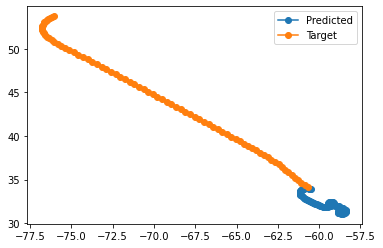

In [11]:
plt.plot(outp_trace[:,0].detach().numpy(), outp_trace[:,1].detach().numpy(), marker='o', label='Predicted')
plt.plot(target[:,0].detach().numpy(), target[:,1].detach().numpy(), marker='o', label='Target')
plt.legend()

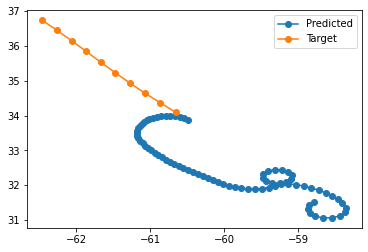

In [12]:
plt.plot(outp_trace[:,0].detach().numpy(), outp_trace[:,1].detach().numpy(), marker='o', label='Predicted')
plt.plot(target[:10,0].detach().numpy(), target[:10,1].detach().numpy(), marker='o', label='Target')
plt.legend()

In [13]:
loss = nn.MSELoss()
loss(outp_trace,torch.tensor(train_frame.iloc[0]['target'], dtype=torch.float32))

tensor(125.7420, grad_fn=<MseLossBackward0>)

  0%|          | 0/470 [00:00<?, ?it/s]

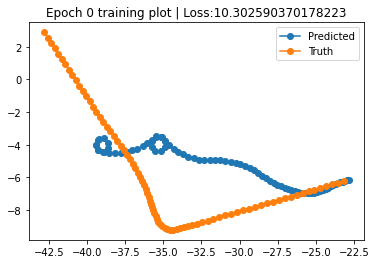

44.93092567869957


  0%|          | 0/118 [00:00<?, ?it/s]

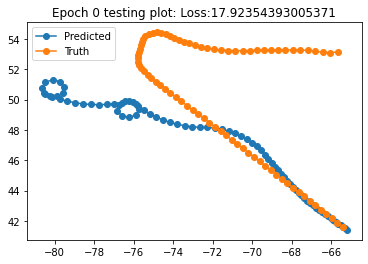

28.684531700813164
Epoch 0 | Train Loss: 44.93092567869957 | Test Loss: 28.684531700813164


  0%|          | 0/470 [00:00<?, ?it/s]

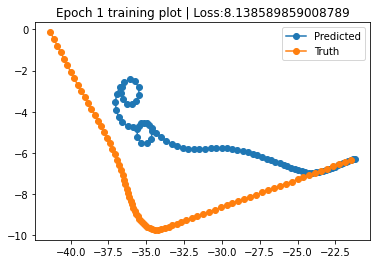

28.22096183502928


  0%|          | 0/118 [00:00<?, ?it/s]

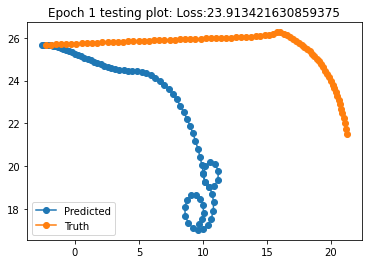

24.32101100178088
Epoch 1 | Train Loss: 28.22096183502928 | Test Loss: 24.32101100178088


  0%|          | 0/470 [00:00<?, ?it/s]

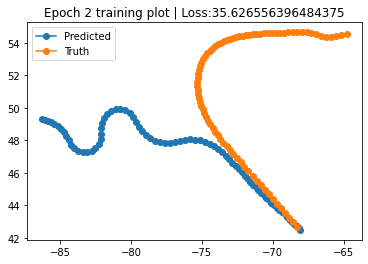

26.249522021729895


  0%|          | 0/118 [00:00<?, ?it/s]

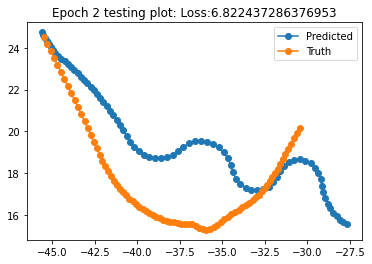

23.252854401782407
Epoch 2 | Train Loss: 26.249522021729895 | Test Loss: 23.252854401782407


  0%|          | 0/470 [00:00<?, ?it/s]

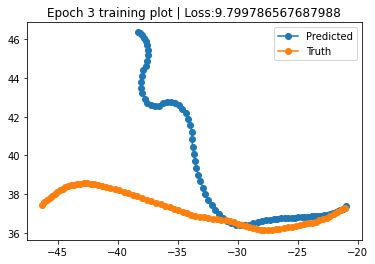

22.172150404909825


  0%|          | 0/118 [00:00<?, ?it/s]

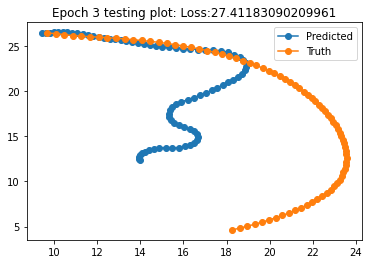

21.914374753580255
Epoch 3 | Train Loss: 22.172150404909825 | Test Loss: 21.914374753580255


  0%|          | 0/470 [00:00<?, ?it/s]

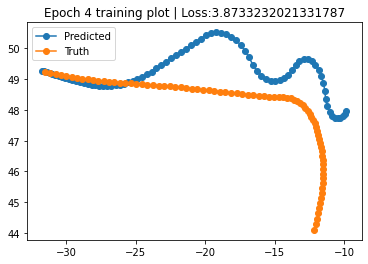

22.405995708069902


  0%|          | 0/118 [00:00<?, ?it/s]

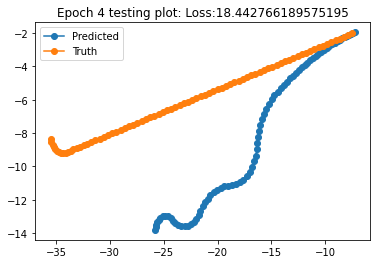

20.353119935019542
Epoch 4 | Train Loss: 22.405995708069902 | Test Loss: 20.353119935019542


  0%|          | 0/470 [00:00<?, ?it/s]

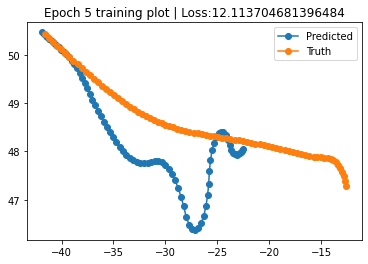

20.86011291412597


  0%|          | 0/118 [00:00<?, ?it/s]

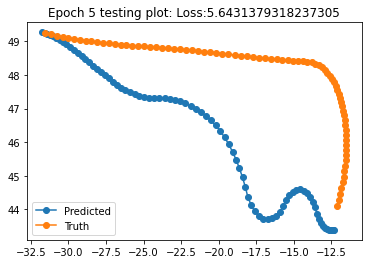

22.805669672408346
Epoch 5 | Train Loss: 20.86011291412597 | Test Loss: 22.805669672408346


  0%|          | 0/470 [00:00<?, ?it/s]

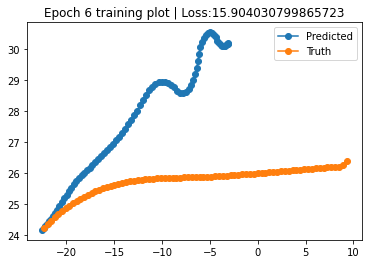

19.57633102980066


  0%|          | 0/118 [00:00<?, ?it/s]

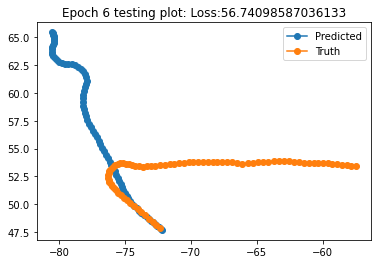

17.219226817963488
Epoch 6 | Train Loss: 19.57633102980066 | Test Loss: 17.219226817963488


  0%|          | 0/470 [00:00<?, ?it/s]

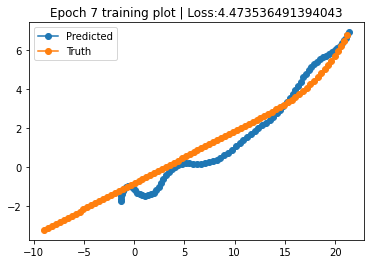

20.070174091293456


  0%|          | 0/118 [00:00<?, ?it/s]

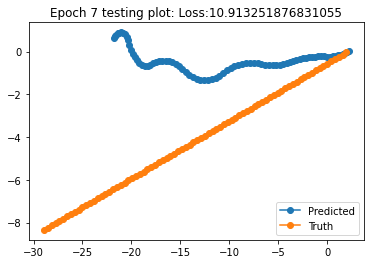

19.707398097899002
Epoch 7 | Train Loss: 20.070174091293456 | Test Loss: 19.707398097899002


  0%|          | 0/470 [00:00<?, ?it/s]

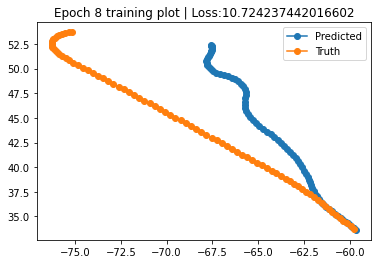

18.72678725935043


  0%|          | 0/118 [00:00<?, ?it/s]

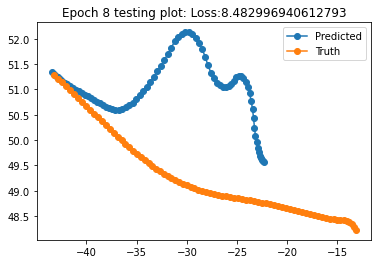

15.081266864881677
Epoch 8 | Train Loss: 18.72678725935043 | Test Loss: 15.081266864881677


  0%|          | 0/470 [00:00<?, ?it/s]

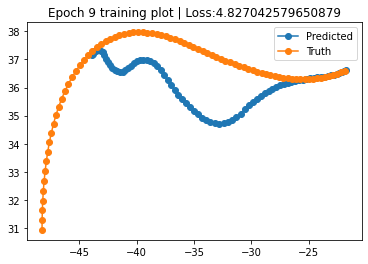

18.366934895769077


  0%|          | 0/118 [00:00<?, ?it/s]

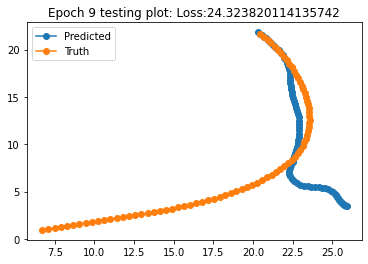

16.05748047869084
Epoch 9 | Train Loss: 18.366934895769077 | Test Loss: 16.05748047869084


  0%|          | 0/470 [00:00<?, ?it/s]

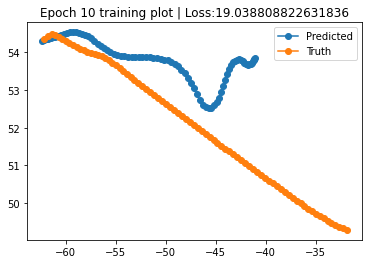

17.00713599527136


  0%|          | 0/118 [00:00<?, ?it/s]

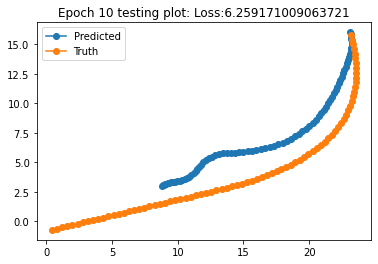

17.014073514332207
Epoch 10 | Train Loss: 17.00713599527136 | Test Loss: 17.014073514332207


  0%|          | 0/470 [00:00<?, ?it/s]

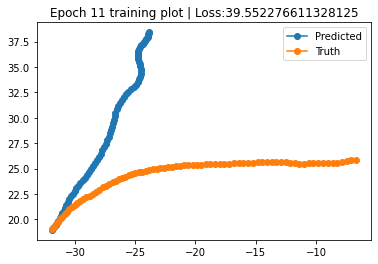

17.23943879020975


  0%|          | 0/118 [00:00<?, ?it/s]

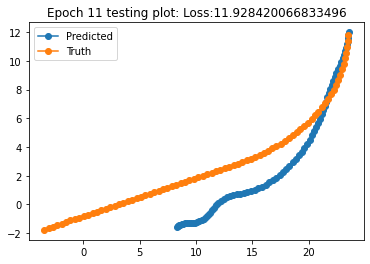

14.54620378300295
Epoch 11 | Train Loss: 17.23943879020975 | Test Loss: 14.54620378300295


  0%|          | 0/470 [00:00<?, ?it/s]

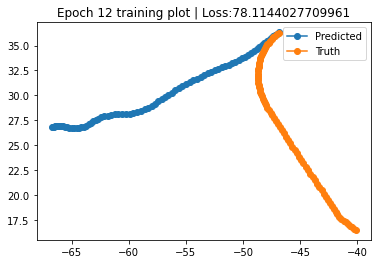

16.608137369916793


  0%|          | 0/118 [00:00<?, ?it/s]

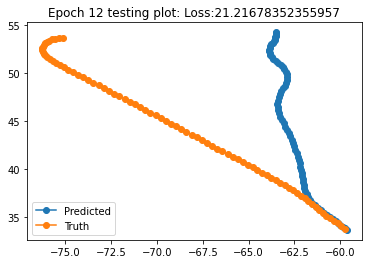

22.25818885989108
Epoch 12 | Train Loss: 16.608137369916793 | Test Loss: 22.25818885989108


  0%|          | 0/470 [00:00<?, ?it/s]

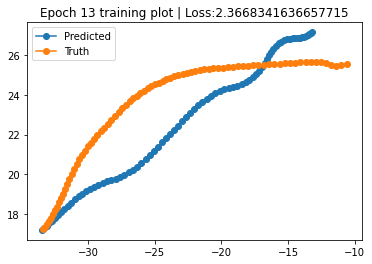

15.50234543896736


  0%|          | 0/118 [00:00<?, ?it/s]

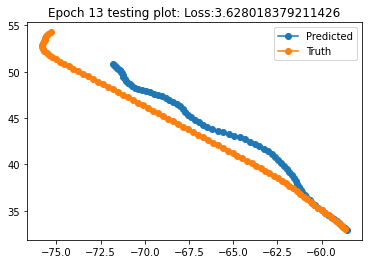

13.663941718764224
Epoch 13 | Train Loss: 15.50234543896736 | Test Loss: 13.663941718764224


  0%|          | 0/470 [00:00<?, ?it/s]

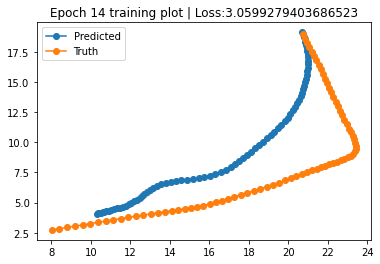

16.52605427085085


  0%|          | 0/118 [00:00<?, ?it/s]

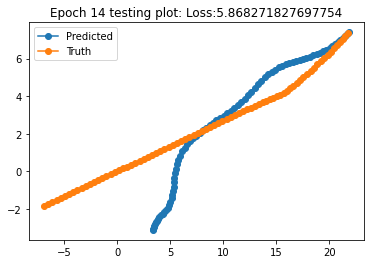

14.137624202138287
Epoch 14 | Train Loss: 16.52605427085085 | Test Loss: 14.137624202138287


  0%|          | 0/470 [00:00<?, ?it/s]

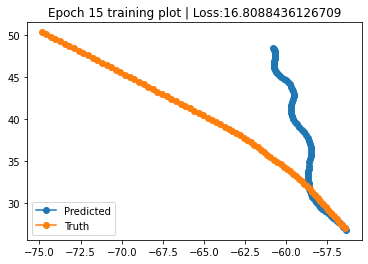

15.846160020473155


  0%|          | 0/118 [00:00<?, ?it/s]

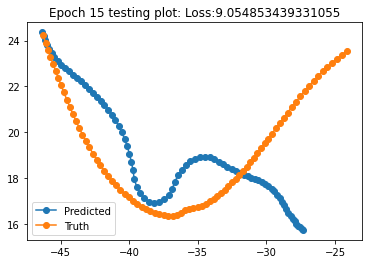

13.179383652695154
Epoch 15 | Train Loss: 15.846160020473155 | Test Loss: 13.179383652695154


  0%|          | 0/470 [00:00<?, ?it/s]

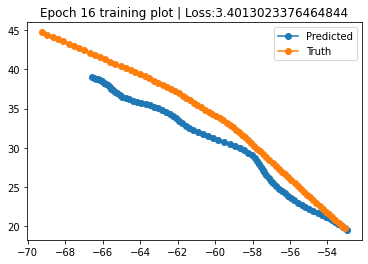

16.050567014420285


  0%|          | 0/118 [00:00<?, ?it/s]

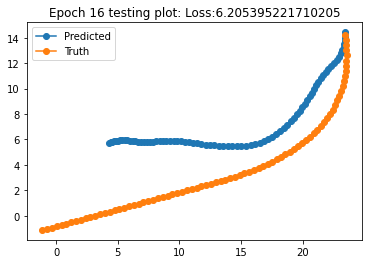

12.213378456689544
Epoch 16 | Train Loss: 16.050567014420285 | Test Loss: 12.213378456689544


  0%|          | 0/470 [00:00<?, ?it/s]

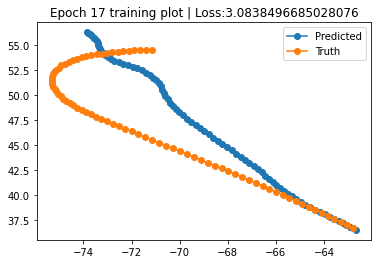

15.292545628801305


  0%|          | 0/118 [00:00<?, ?it/s]

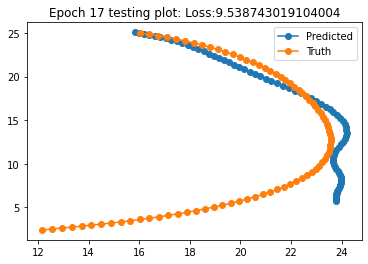

12.338539197283277
Epoch 17 | Train Loss: 15.292545628801305 | Test Loss: 12.338539197283277


  0%|          | 0/470 [00:00<?, ?it/s]

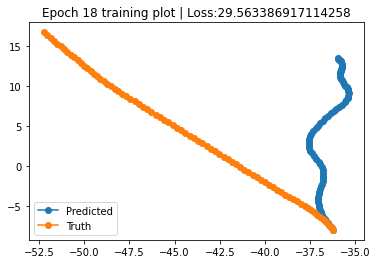

14.887662974317022


  0%|          | 0/118 [00:00<?, ?it/s]

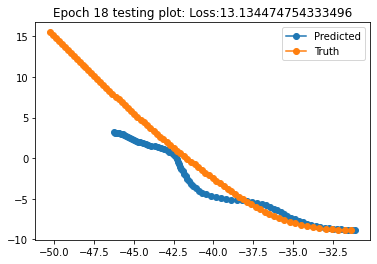

15.566525136010121
Epoch 18 | Train Loss: 14.887662974317022 | Test Loss: 15.566525136010121


  0%|          | 0/470 [00:00<?, ?it/s]

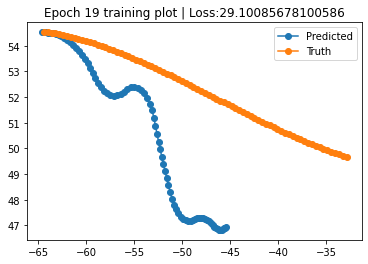

14.855771819200921


  0%|          | 0/118 [00:00<?, ?it/s]

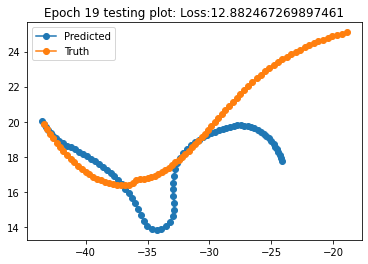

12.533885668394928
Epoch 19 | Train Loss: 14.855771819200921 | Test Loss: 12.533885668394928


  0%|          | 0/470 [00:00<?, ?it/s]

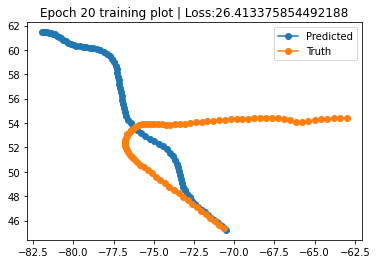

14.734181218832097


  0%|          | 0/118 [00:00<?, ?it/s]

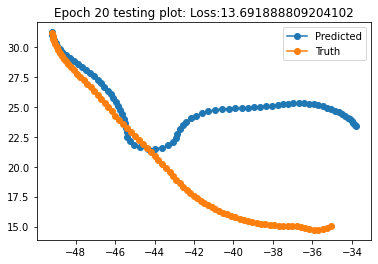

15.128817768420204
Epoch 20 | Train Loss: 14.734181218832097 | Test Loss: 15.128817768420204


  0%|          | 0/470 [00:00<?, ?it/s]

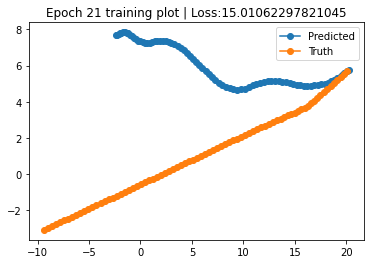

15.555083570328165


  0%|          | 0/118 [00:00<?, ?it/s]

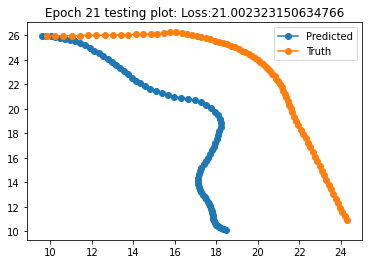

14.649343710834698
Epoch 21 | Train Loss: 15.555083570328165 | Test Loss: 14.649343710834698


  0%|          | 0/470 [00:00<?, ?it/s]

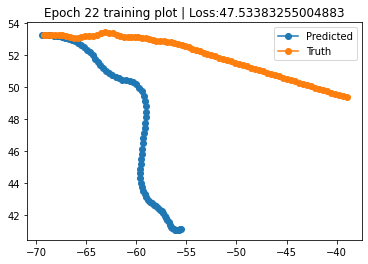

14.224060185412144


  0%|          | 0/118 [00:00<?, ?it/s]

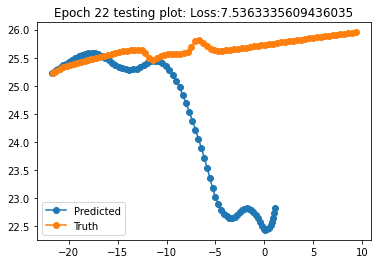

11.803165573184772
Epoch 22 | Train Loss: 14.224060185412144 | Test Loss: 11.803165573184772


  0%|          | 0/470 [00:00<?, ?it/s]

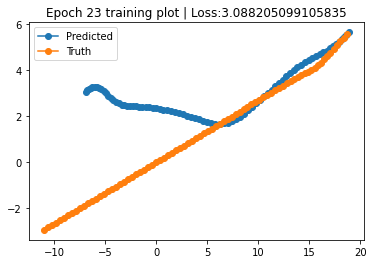

14.567914491130951


  0%|          | 0/118 [00:00<?, ?it/s]

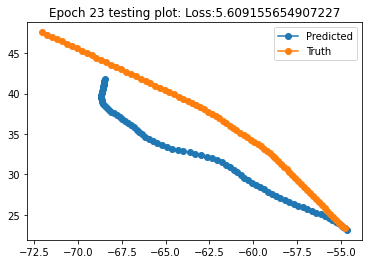

11.705867080365197
Epoch 23 | Train Loss: 14.567914491130951 | Test Loss: 11.705867080365197


  0%|          | 0/470 [00:00<?, ?it/s]

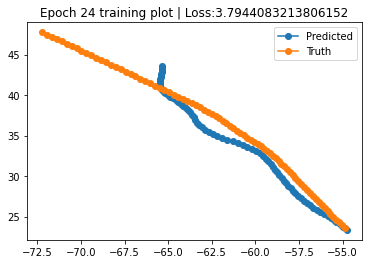

13.571227459704623


  0%|          | 0/118 [00:00<?, ?it/s]

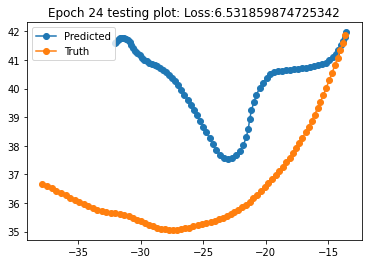

11.988631335860592
Epoch 24 | Train Loss: 13.571227459704623 | Test Loss: 11.988631335860592


  0%|          | 0/470 [00:00<?, ?it/s]

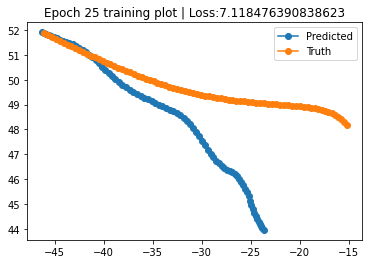

13.285269476505036


  0%|          | 0/118 [00:00<?, ?it/s]

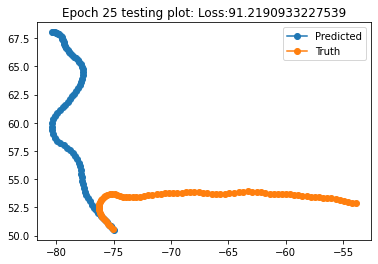

11.032416472495612
Epoch 25 | Train Loss: 13.285269476505036 | Test Loss: 11.032416472495612


  0%|          | 0/470 [00:00<?, ?it/s]

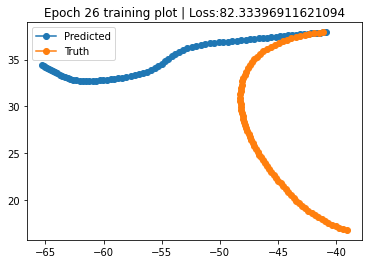

13.395363088364297


  0%|          | 0/118 [00:00<?, ?it/s]

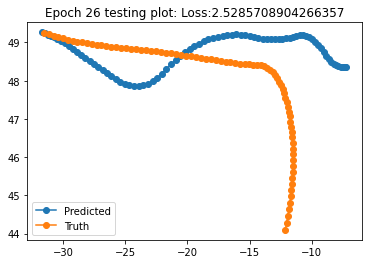

16.374181823710263
Epoch 26 | Train Loss: 13.395363088364297 | Test Loss: 16.374181823710263


  0%|          | 0/470 [00:00<?, ?it/s]

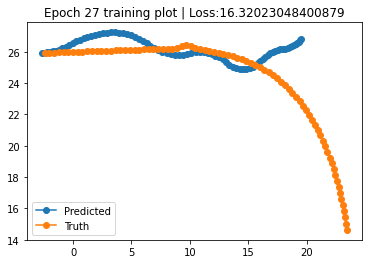

13.60836235310169


  0%|          | 0/118 [00:00<?, ?it/s]

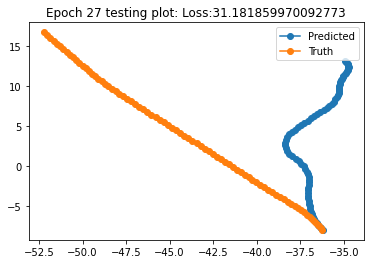

11.29985481904725
Epoch 27 | Train Loss: 13.60836235310169 | Test Loss: 11.29985481904725


  0%|          | 0/470 [00:00<?, ?it/s]

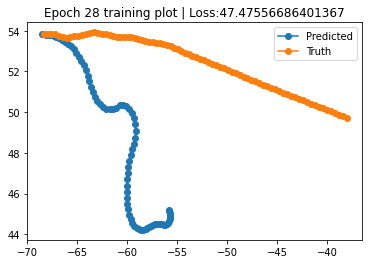

14.051973188937978


  0%|          | 0/118 [00:00<?, ?it/s]

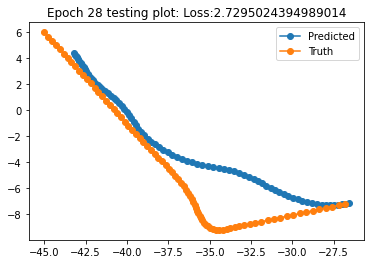

10.9112035056292
Epoch 28 | Train Loss: 14.051973188937978 | Test Loss: 10.9112035056292


  0%|          | 0/470 [00:00<?, ?it/s]

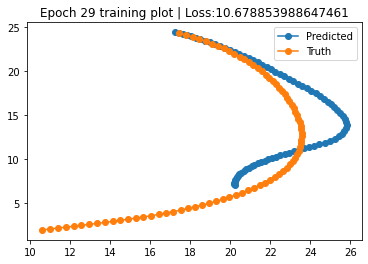

12.989037529458392


  0%|          | 0/118 [00:00<?, ?it/s]

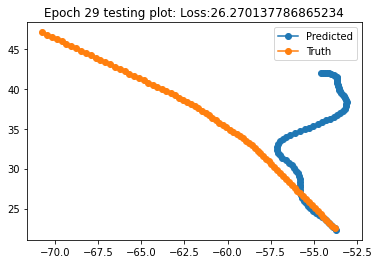

13.0490771370419
Epoch 29 | Train Loss: 12.989037529458392 | Test Loss: 13.0490771370419


  0%|          | 0/470 [00:00<?, ?it/s]

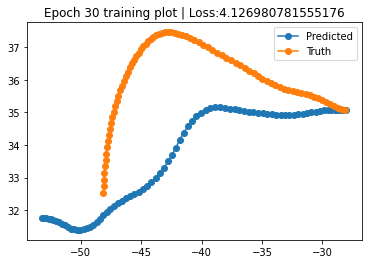

13.325955554018629


  0%|          | 0/118 [00:00<?, ?it/s]

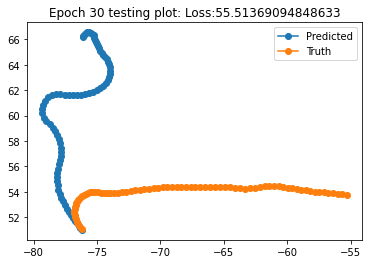

9.902958168316696
Epoch 30 | Train Loss: 13.325955554018629 | Test Loss: 9.902958168316696


  0%|          | 0/470 [00:00<?, ?it/s]

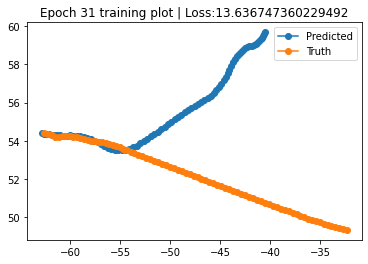

12.614617080257293


  0%|          | 0/118 [00:00<?, ?it/s]

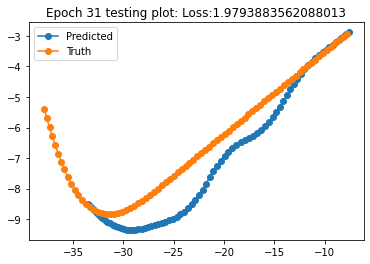

10.825249508780947
Epoch 31 | Train Loss: 12.614617080257293 | Test Loss: 10.825249508780947


  0%|          | 0/470 [00:00<?, ?it/s]

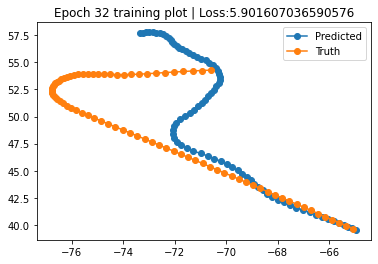

12.683790410325882


  0%|          | 0/118 [00:00<?, ?it/s]

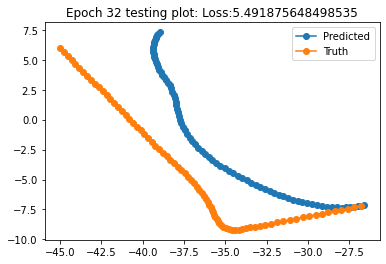

10.347270789287858
Epoch 32 | Train Loss: 12.683790410325882 | Test Loss: 10.347270789287858


  0%|          | 0/470 [00:00<?, ?it/s]

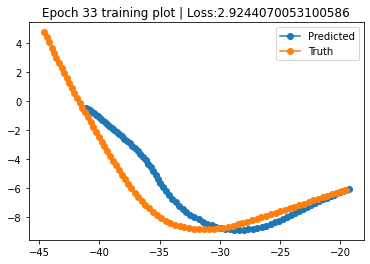

11.695201956211253


  0%|          | 0/118 [00:00<?, ?it/s]

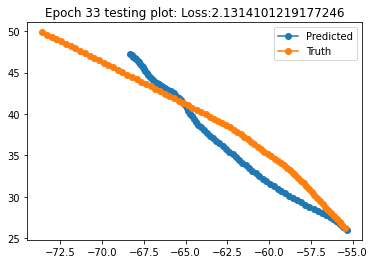

10.128396238310863
Epoch 33 | Train Loss: 11.695201956211253 | Test Loss: 10.128396238310863


  0%|          | 0/470 [00:00<?, ?it/s]

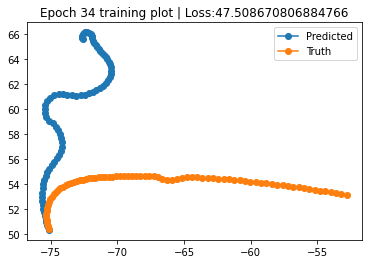

12.55353060859315


  0%|          | 0/118 [00:00<?, ?it/s]

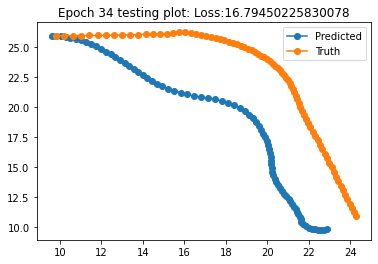

10.834217585749546
Epoch 34 | Train Loss: 12.55353060859315 | Test Loss: 10.834217585749546


  0%|          | 0/470 [00:00<?, ?it/s]

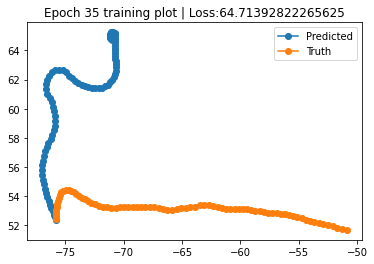

12.251002298263794


  0%|          | 0/118 [00:00<?, ?it/s]

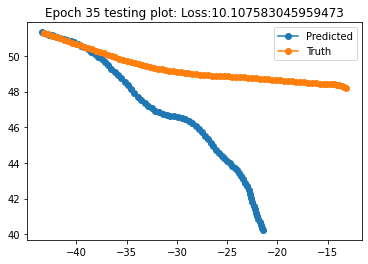

19.72871025133941
Epoch 35 | Train Loss: 12.251002298263794 | Test Loss: 19.72871025133941


  0%|          | 0/470 [00:00<?, ?it/s]

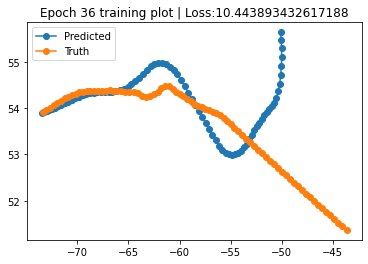

12.184092695535497


  0%|          | 0/118 [00:00<?, ?it/s]

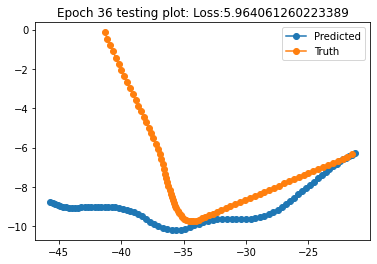

13.165202496415478
Epoch 36 | Train Loss: 12.184092695535497 | Test Loss: 13.165202496415478


  0%|          | 0/470 [00:00<?, ?it/s]

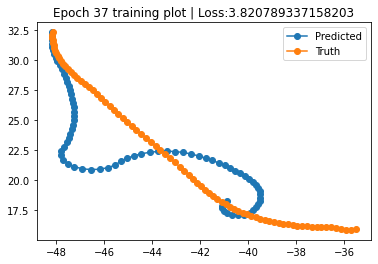

12.505145262023236


  0%|          | 0/118 [00:00<?, ?it/s]

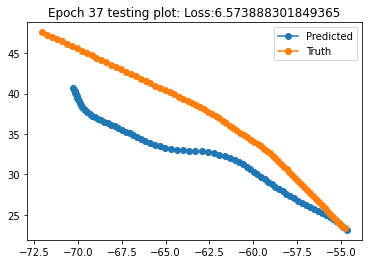

10.948064548989473
Epoch 37 | Train Loss: 12.505145262023236 | Test Loss: 10.948064548989473


  0%|          | 0/470 [00:00<?, ?it/s]

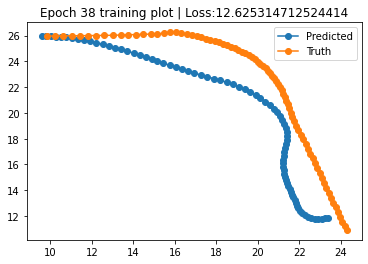

12.10338217476581


  0%|          | 0/118 [00:00<?, ?it/s]

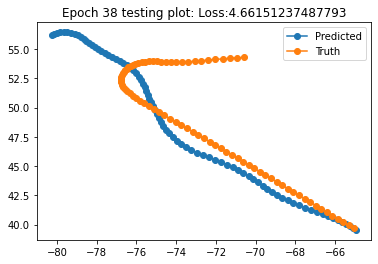

9.588296617491771
Epoch 38 | Train Loss: 12.10338217476581 | Test Loss: 9.588296617491771


  0%|          | 0/470 [00:00<?, ?it/s]

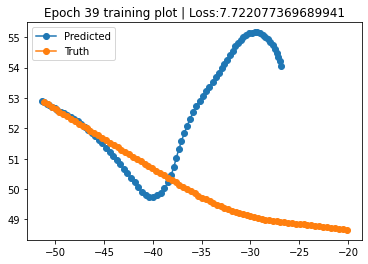

12.141260974457923


  0%|          | 0/118 [00:00<?, ?it/s]

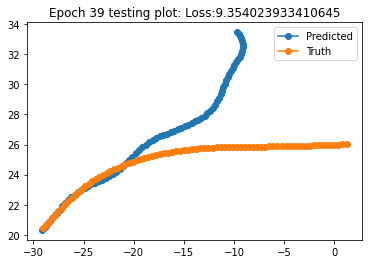

10.241385888750271
Epoch 39 | Train Loss: 12.141260974457923 | Test Loss: 10.241385888750271


  0%|          | 0/470 [00:00<?, ?it/s]

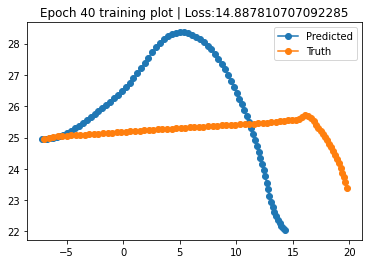

12.394223119477008


  0%|          | 0/118 [00:00<?, ?it/s]

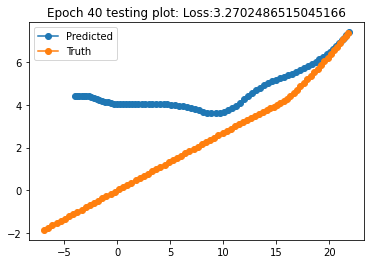

9.793322755118547
Epoch 40 | Train Loss: 12.394223119477008 | Test Loss: 9.793322755118547


  0%|          | 0/470 [00:00<?, ?it/s]

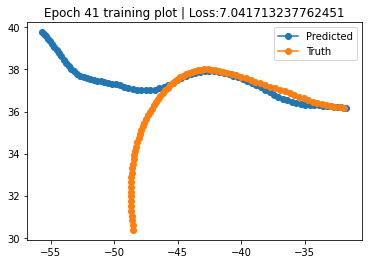

11.558537262170873


  0%|          | 0/118 [00:00<?, ?it/s]

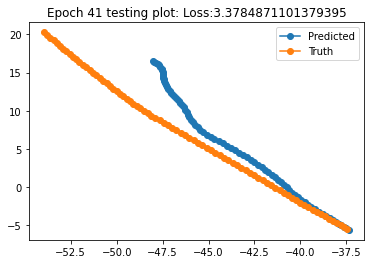

10.002140799821433
Epoch 41 | Train Loss: 11.558537262170873 | Test Loss: 10.002140799821433


  0%|          | 0/470 [00:00<?, ?it/s]

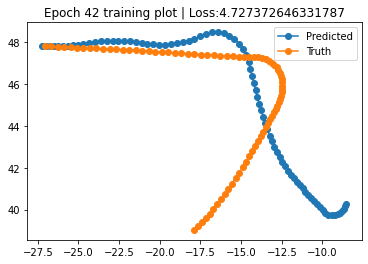

11.75649959736682


  0%|          | 0/118 [00:00<?, ?it/s]

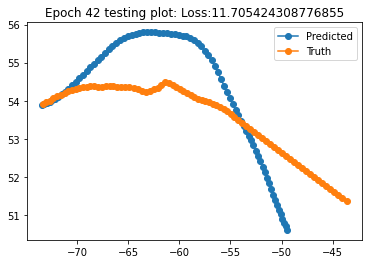

9.532180599236893
Epoch 42 | Train Loss: 11.75649959736682 | Test Loss: 9.532180599236893


  0%|          | 0/470 [00:00<?, ?it/s]

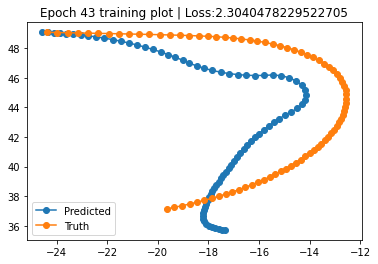

12.166186084772677


  0%|          | 0/118 [00:00<?, ?it/s]

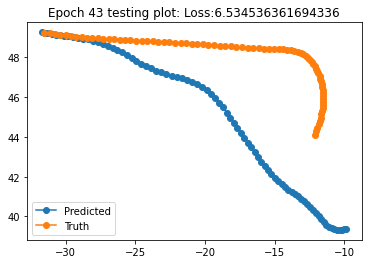

9.669425099582995
Epoch 43 | Train Loss: 12.166186084772677 | Test Loss: 9.669425099582995


  0%|          | 0/470 [00:00<?, ?it/s]

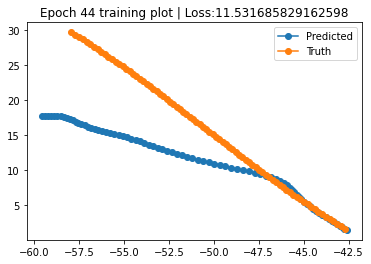

11.384877416428099


  0%|          | 0/118 [00:00<?, ?it/s]

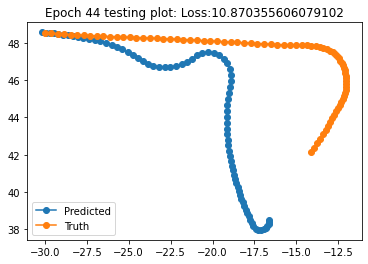

11.093181765685648
Epoch 44 | Train Loss: 11.384877416428099 | Test Loss: 11.093181765685648


  0%|          | 0/470 [00:00<?, ?it/s]

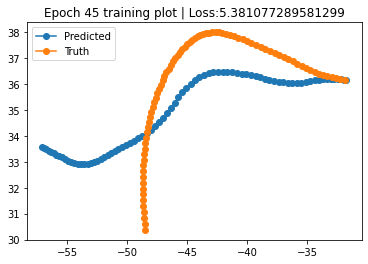

11.241237695990725


  0%|          | 0/118 [00:00<?, ?it/s]

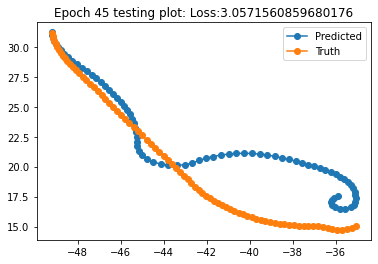

8.598263441000954
Epoch 45 | Train Loss: 11.241237695990725 | Test Loss: 8.598263441000954


  0%|          | 0/470 [00:00<?, ?it/s]

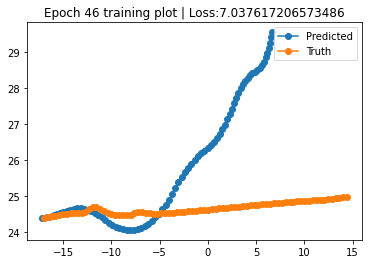

11.229563239787486


  0%|          | 0/118 [00:00<?, ?it/s]

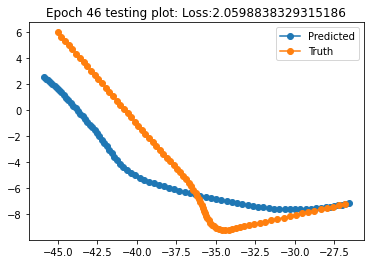

8.76910293556876
Epoch 46 | Train Loss: 11.229563239787486 | Test Loss: 8.76910293556876


  0%|          | 0/470 [00:00<?, ?it/s]

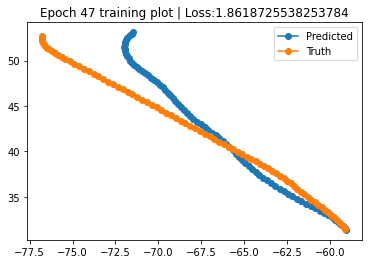

11.089391589164734


  0%|          | 0/118 [00:00<?, ?it/s]

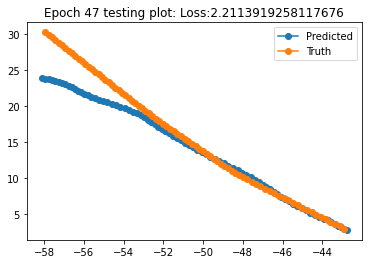

8.988527406070192
Epoch 47 | Train Loss: 11.089391589164734 | Test Loss: 8.988527406070192


  0%|          | 0/470 [00:00<?, ?it/s]

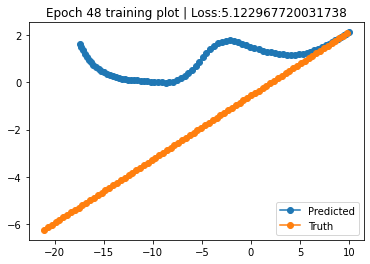

11.014647572249809


  0%|          | 0/118 [00:00<?, ?it/s]

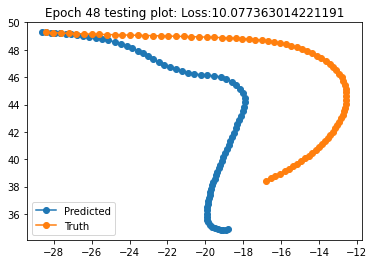

11.834695633690236
Epoch 48 | Train Loss: 11.014647572249809 | Test Loss: 11.834695633690236


  0%|          | 0/470 [00:00<?, ?it/s]

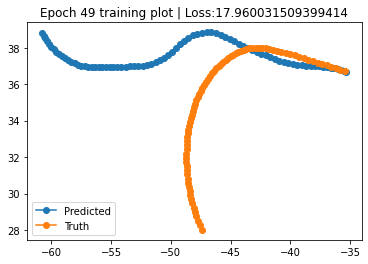

11.307671499569365


  0%|          | 0/118 [00:00<?, ?it/s]

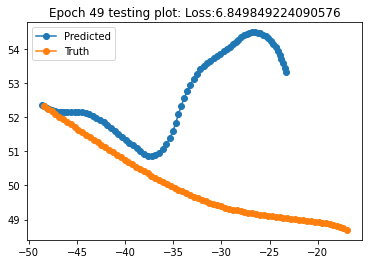

8.486724124116412
Epoch 49 | Train Loss: 11.307671499569365 | Test Loss: 8.486724124116412


  0%|          | 0/470 [00:00<?, ?it/s]

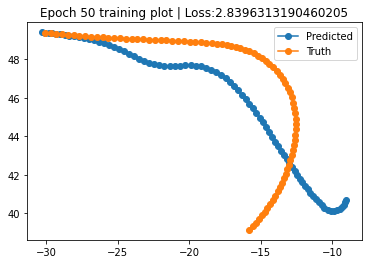

10.66502611434206


  0%|          | 0/118 [00:00<?, ?it/s]

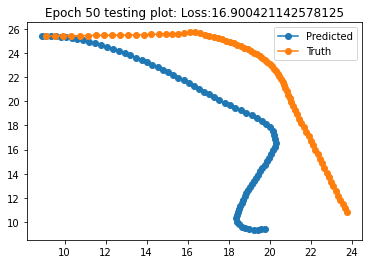

10.245707914990893
Epoch 50 | Train Loss: 10.66502611434206 | Test Loss: 10.245707914990893


  0%|          | 0/470 [00:00<?, ?it/s]

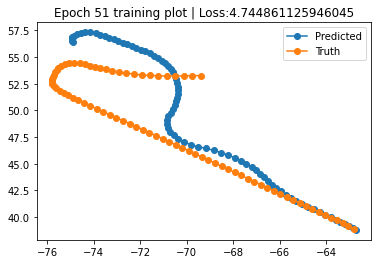

10.701218748663335


  0%|          | 0/118 [00:00<?, ?it/s]

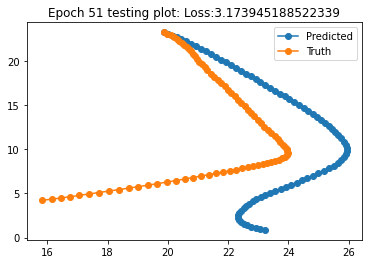

11.81497890211768
Epoch 51 | Train Loss: 10.701218748663335 | Test Loss: 11.81497890211768


  0%|          | 0/470 [00:00<?, ?it/s]

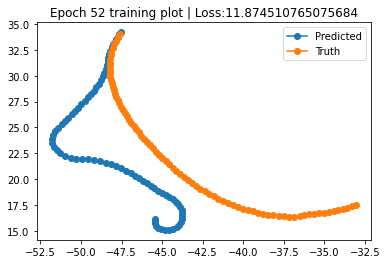

10.630653756032599


  0%|          | 0/118 [00:00<?, ?it/s]

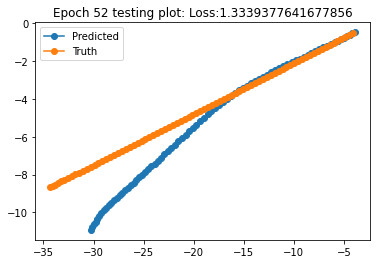

8.732926410386117
Epoch 52 | Train Loss: 10.630653756032599 | Test Loss: 8.732926410386117


  0%|          | 0/470 [00:00<?, ?it/s]

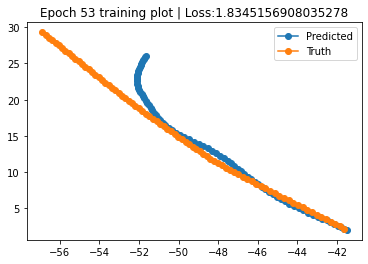

10.484283450245858


  0%|          | 0/118 [00:00<?, ?it/s]

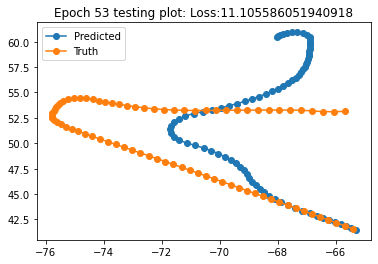

11.251261778302112
Epoch 53 | Train Loss: 10.484283450245858 | Test Loss: 11.251261778302112


  0%|          | 0/470 [00:00<?, ?it/s]

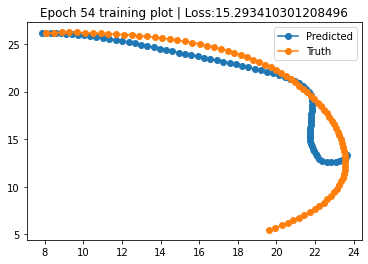

10.835453124819917


  0%|          | 0/118 [00:00<?, ?it/s]

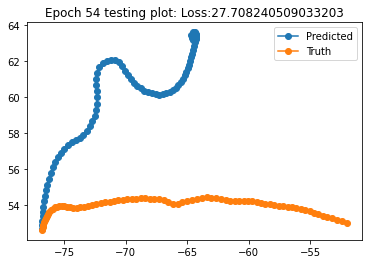

8.52520032681651
Epoch 54 | Train Loss: 10.835453124819917 | Test Loss: 8.52520032681651


  0%|          | 0/470 [00:00<?, ?it/s]

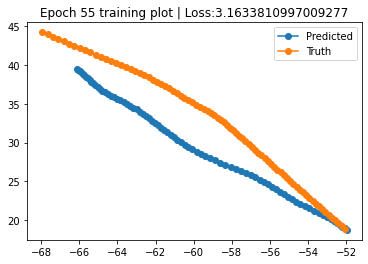

11.053548033345253


  0%|          | 0/118 [00:00<?, ?it/s]

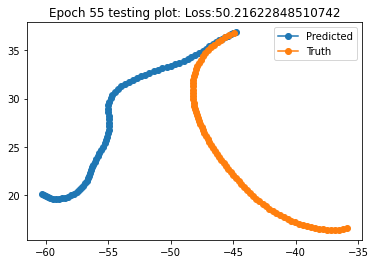

8.79265027455354
Epoch 55 | Train Loss: 11.053548033345253 | Test Loss: 8.79265027455354


  0%|          | 0/470 [00:00<?, ?it/s]

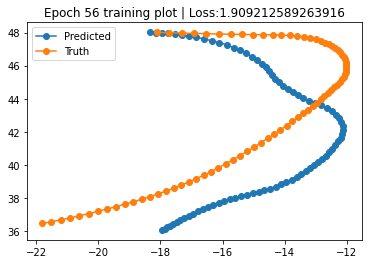

10.41551310052263


  0%|          | 0/118 [00:00<?, ?it/s]

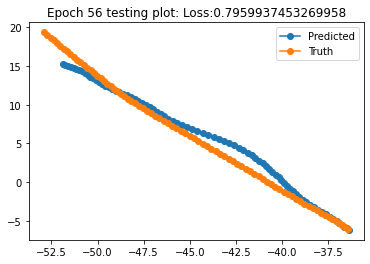

8.050387653758971
Epoch 56 | Train Loss: 10.41551310052263 | Test Loss: 8.050387653758971


  0%|          | 0/470 [00:00<?, ?it/s]

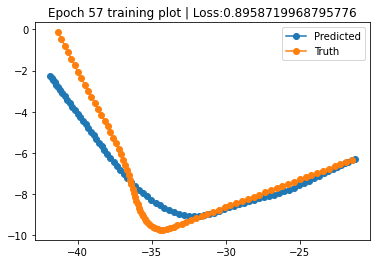

10.343712152191934


  0%|          | 0/118 [00:00<?, ?it/s]

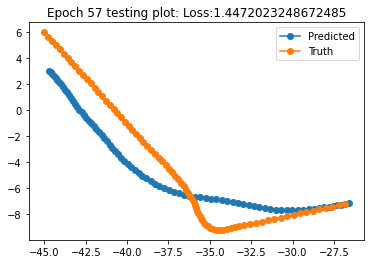

8.972431692531554
Epoch 57 | Train Loss: 10.343712152191934 | Test Loss: 8.972431692531554


  0%|          | 0/470 [00:00<?, ?it/s]

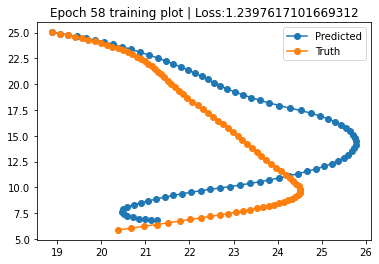

10.655990611745956


  0%|          | 0/118 [00:00<?, ?it/s]

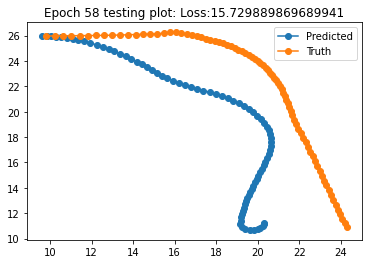

9.218992855084144
Epoch 58 | Train Loss: 10.655990611745956 | Test Loss: 9.218992855084144


  0%|          | 0/470 [00:00<?, ?it/s]

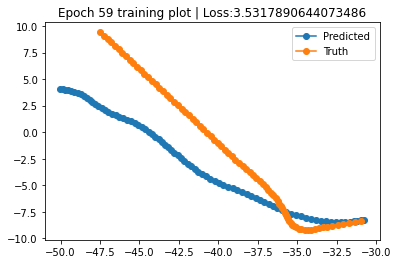

10.271437205152308


  0%|          | 0/118 [00:00<?, ?it/s]

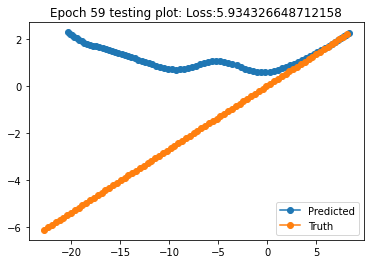

9.585547812914443
Epoch 59 | Train Loss: 10.271437205152308 | Test Loss: 9.585547812914443


  0%|          | 0/470 [00:00<?, ?it/s]

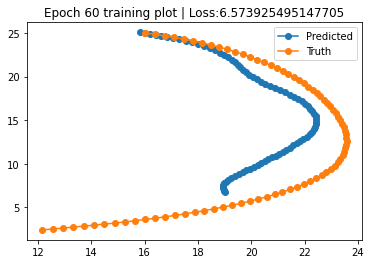

10.284588170241802


  0%|          | 0/118 [00:00<?, ?it/s]

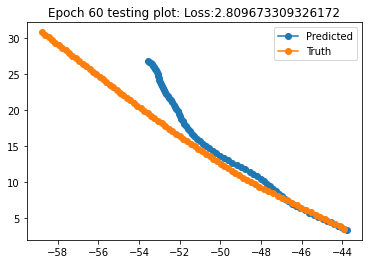

8.86447331006244
Epoch 60 | Train Loss: 10.284588170241802 | Test Loss: 8.86447331006244


  0%|          | 0/470 [00:00<?, ?it/s]

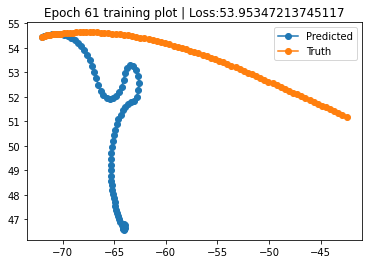

10.196117811063504


  0%|          | 0/118 [00:00<?, ?it/s]

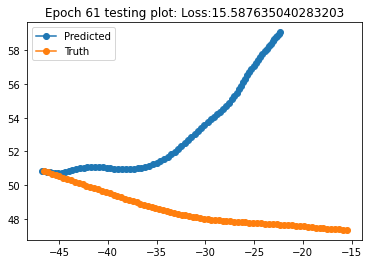

11.8864474834527
Epoch 61 | Train Loss: 10.196117811063504 | Test Loss: 11.8864474834527


  0%|          | 0/470 [00:00<?, ?it/s]

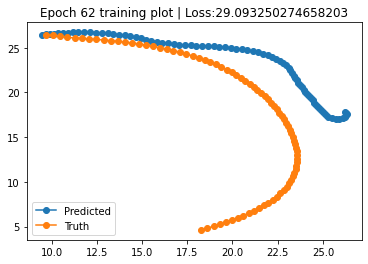

11.172721059017993


  0%|          | 0/118 [00:00<?, ?it/s]

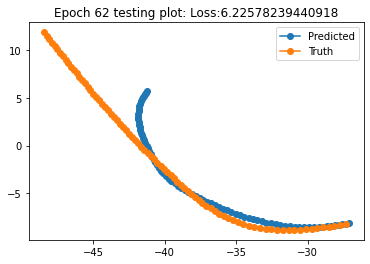

8.930524883381391
Epoch 62 | Train Loss: 11.172721059017993 | Test Loss: 8.930524883381391


  0%|          | 0/470 [00:00<?, ?it/s]

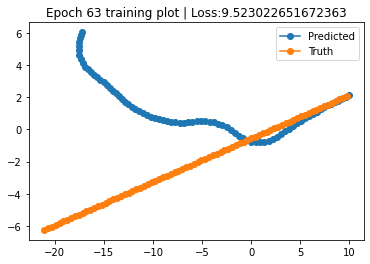

10.066058135793565


  0%|          | 0/118 [00:00<?, ?it/s]

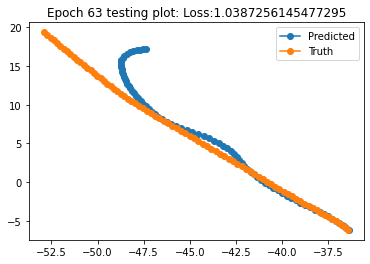

12.440902134624578
Epoch 63 | Train Loss: 10.066058135793565 | Test Loss: 12.440902134624578


  0%|          | 0/470 [00:00<?, ?it/s]

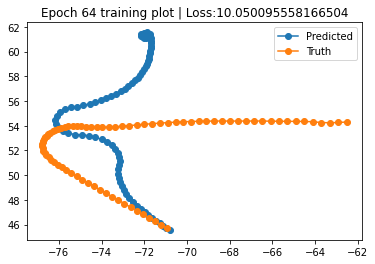

10.56925997810161


  0%|          | 0/118 [00:00<?, ?it/s]

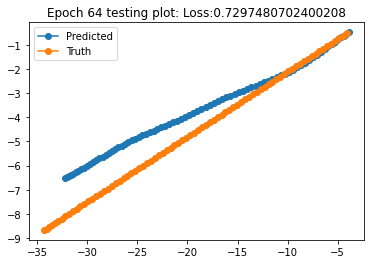

7.864304014434249
Epoch 64 | Train Loss: 10.56925997810161 | Test Loss: 7.864304014434249


  0%|          | 0/470 [00:00<?, ?it/s]

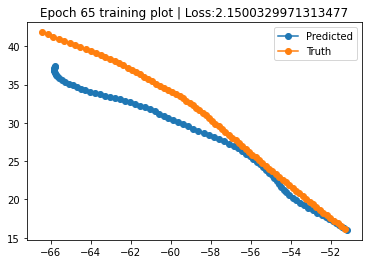

10.599734509086355


  0%|          | 0/118 [00:00<?, ?it/s]

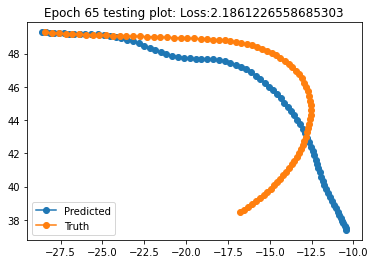

9.2639680151212
Epoch 65 | Train Loss: 10.599734509086355 | Test Loss: 9.2639680151212


  0%|          | 0/470 [00:00<?, ?it/s]

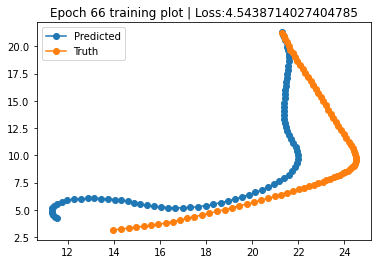

9.444483946041858


  0%|          | 0/118 [00:00<?, ?it/s]

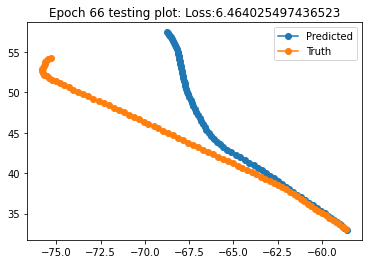

8.722525238738221
Epoch 66 | Train Loss: 9.444483946041858 | Test Loss: 8.722525238738221


  0%|          | 0/470 [00:00<?, ?it/s]

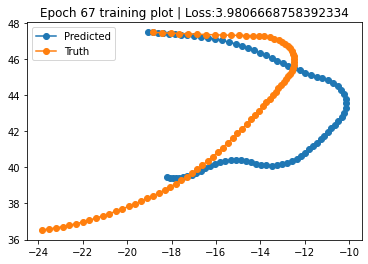

10.038358836256442


  0%|          | 0/118 [00:00<?, ?it/s]

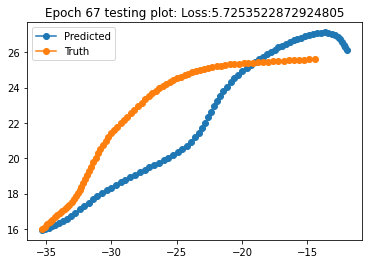

7.1601267989914295
Epoch 67 | Train Loss: 10.038358836256442 | Test Loss: 7.1601267989914295


  0%|          | 0/470 [00:00<?, ?it/s]

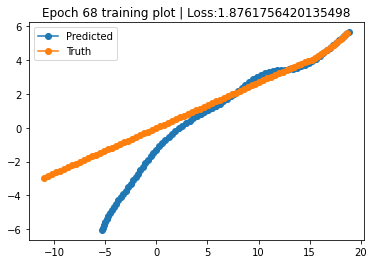

9.612010471713036


  0%|          | 0/118 [00:00<?, ?it/s]

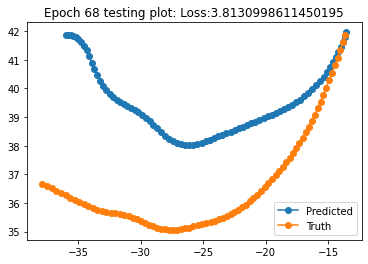

8.238614123125197
Epoch 68 | Train Loss: 9.612010471713036 | Test Loss: 8.238614123125197


  0%|          | 0/470 [00:00<?, ?it/s]

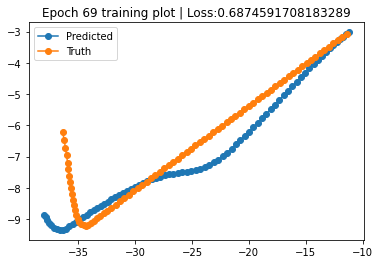

9.245675429226235


  0%|          | 0/118 [00:00<?, ?it/s]

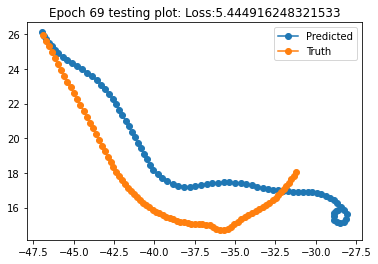

8.447080066774861
Epoch 69 | Train Loss: 9.245675429226235 | Test Loss: 8.447080066774861


  0%|          | 0/470 [00:00<?, ?it/s]

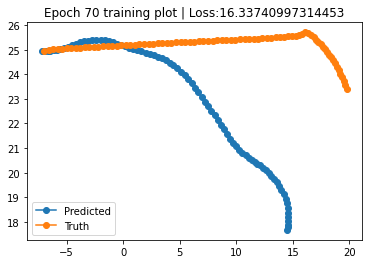

9.515250208561724


  0%|          | 0/118 [00:00<?, ?it/s]

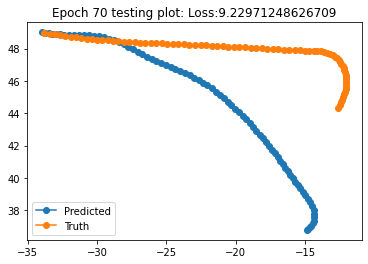

9.028258537336932
Epoch 70 | Train Loss: 9.515250208561724 | Test Loss: 9.028258537336932


  0%|          | 0/470 [00:00<?, ?it/s]

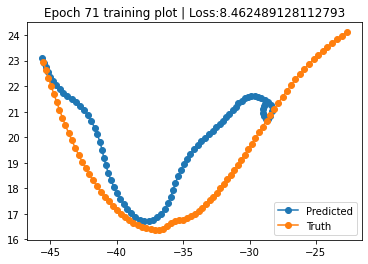

9.65551216640371


  0%|          | 0/118 [00:00<?, ?it/s]

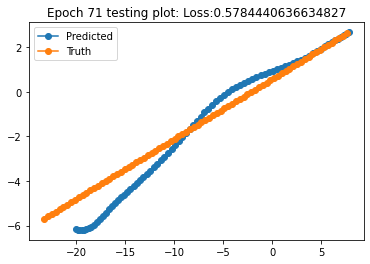

7.1608168448684575
Epoch 71 | Train Loss: 9.65551216640371 | Test Loss: 7.1608168448684575


  0%|          | 0/470 [00:00<?, ?it/s]

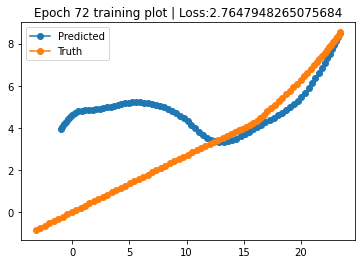

9.19504353017249


  0%|          | 0/118 [00:00<?, ?it/s]

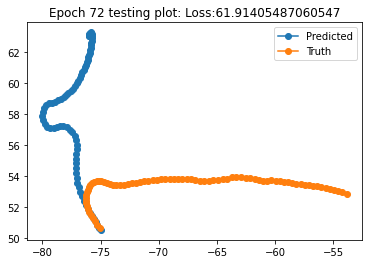

7.375368830258563
Epoch 72 | Train Loss: 9.19504353017249 | Test Loss: 7.375368830258563


  0%|          | 0/470 [00:00<?, ?it/s]

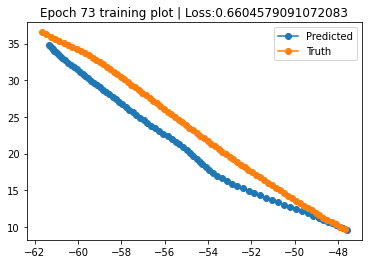

9.726391477692635


  0%|          | 0/118 [00:00<?, ?it/s]

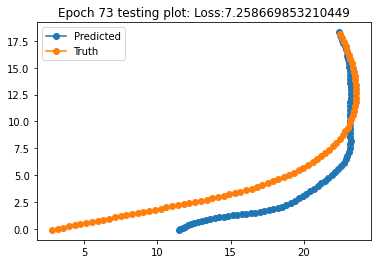

7.990964392231683
Epoch 73 | Train Loss: 9.726391477692635 | Test Loss: 7.990964392231683


  0%|          | 0/470 [00:00<?, ?it/s]

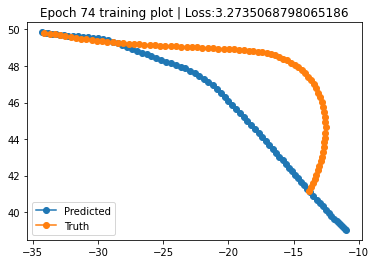

9.003271888037945


  0%|          | 0/118 [00:00<?, ?it/s]

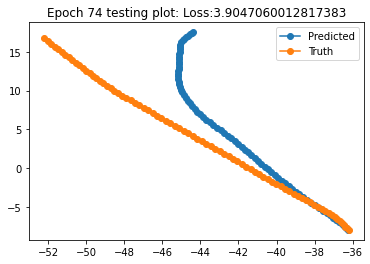

8.097688097822465
Epoch 74 | Train Loss: 9.003271888037945 | Test Loss: 8.097688097822465


  0%|          | 0/470 [00:00<?, ?it/s]

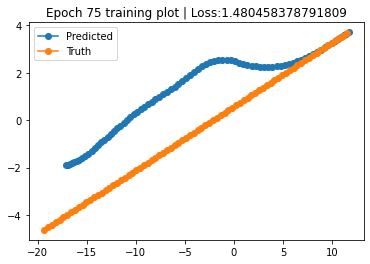

8.78033875464759


  0%|          | 0/118 [00:00<?, ?it/s]

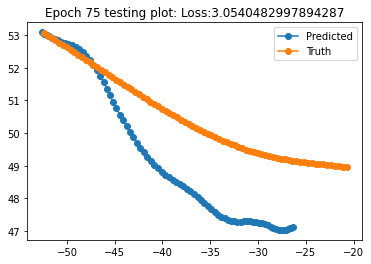

7.876790094678685
Epoch 75 | Train Loss: 8.78033875464759 | Test Loss: 7.876790094678685


  0%|          | 0/470 [00:00<?, ?it/s]

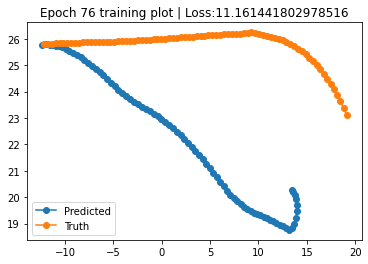

8.795930983031049


  0%|          | 0/118 [00:00<?, ?it/s]

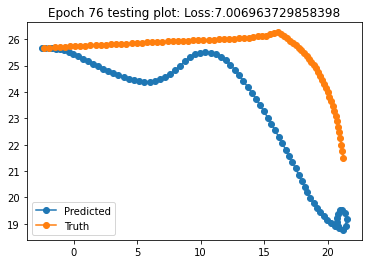

6.916983949936043
Epoch 76 | Train Loss: 8.795930983031049 | Test Loss: 6.916983949936043


  0%|          | 0/470 [00:00<?, ?it/s]

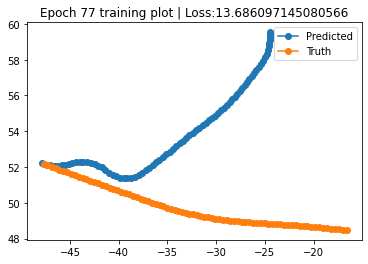

8.859936812234686


  0%|          | 0/118 [00:00<?, ?it/s]

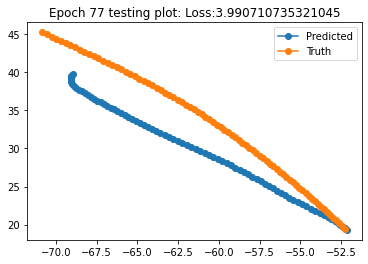

7.759951970587342
Epoch 77 | Train Loss: 8.859936812234686 | Test Loss: 7.759951970587342


  0%|          | 0/470 [00:00<?, ?it/s]

In [ ]:
# Training Loop
torch.autograd.set_detect_anomaly(True)
net = LSTMPredictor()
net.to(DEVICE)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
train_losses = list()
test_losses = list()
BATCH_SIZE = 32

for epoch in range(100):
    cum_train_loss = 0.0
    net.train()
    i=0
    for input_data, target_data in tqdm(train_dataloader):
        if i%BATCH_SIZE == 0:
            net.zero_grad()
        input_data = input_data.squeeze().to(DEVICE)
        outp = net(input_data)
        outp = outp.squeeze()
        outp = outp.to("cpu")
        target_data = target_data.squeeze()
        #print(outp.shape)
        outp_trace = bicycle_model_eval(outp[-1], input_data[-1].detach().clone().to("cpu")).to(DEVICE)
        loss = custom_loss_func(outp_trace, target_data.squeeze().to(DEVICE), outp[-1])
        loss.backward()
        if i%BATCH_SIZE == 0:
            optimizer.step()
        cum_train_loss += loss.item()
    # Catch remainder gradients
    optimizer.step()
    net.zero_grad()
    
    plt.title(f"Epoch {epoch} training plot | Loss:{loss.item()}")
    plt.plot(outp_trace[:,0].detach().cpu().numpy(), outp_trace[:,1].detach().cpu().numpy(), marker='o', label="Predicted")
    plt.plot(target_data[:,0].detach().cpu().numpy(), target_data[:,1].detach().cpu().numpy(), marker='o', label="Truth")
    plt.legend()
    plt.show()
    cum_train_loss /= len(train_dataset)
    train_losses.append(cum_train_loss)
    print(cum_train_loss)
    cum_test_loss = 0.0
    net.eval()
    with torch.no_grad():
        for input_data, target_data in tqdm(test_dataloader):
            input_data = input_data.squeeze().to(DEVICE)
            outp = net(input_data)
            outp = outp.squeeze()
            outp = outp.to("cpu")
            target_data = target_data.squeeze()
            outp_trace = bicycle_model_eval(outp[-1], input_data[-1].detach().clone().to("cpu")).to(DEVICE)
            loss = custom_loss_func(outp_trace, target_data.squeeze().to(DEVICE), outp[-1])
            cum_test_loss += loss.item()
        plt.title(f"Epoch {epoch} testing plot: Loss:{loss.item()}")
        plt.plot(outp_trace[:,0].detach().cpu().numpy(), outp_trace[:,1].detach().cpu().numpy(), marker='o', label="Predicted")
        plt.plot(target_data[:,0].detach().cpu().numpy(), target_data[:,1].detach().cpu().numpy(), marker='o', label="Truth")
        plt.legend()
        plt.show()
    cum_test_loss /= len(test_dataset)
    test_losses.append(cum_test_loss)
    if cum_test_loss <= min(test_losses):
        torch.save(net.state_dict(), "best_stepped_bicycle.pt")
    print(cum_test_loss)
    print(f"Epoch {epoch} | Train Loss: {cum_train_loss} | Test Loss: {cum_test_loss}")

In [ ]:
plt.title(f"Learning Curves")
plt.plot(train_losses, marker='o', label="Training Loss")
plt.plot(test_losses, marker='o', label="Testing Loss")
plt.legend()
plt.show()

In [ ]:
test_losses